# TP EDA — Bike Sharing (données journalières 2011–2012)

**Objectif (1h30)** : produire des *insights* clairs et racontables à partir d’un dataset “réel” (usage vélos + météo + calendrier).

- Livrable : ce notebook rempli + 4–6 graphiques + 5–8 insights rédigés (phrases courtes, chiffrées).
- Interdiction : faire du modèle ML “au hasard” avant d’avoir compris les données.

Dataset original : *Bike Sharing* (UCI). On utilise ici une copie `day.csv` (731 lignes, 1 ligne = 1 jour).  
Colonnes clés : `cnt` (total locations), `casual`, `registered`, météo (`temp`, `hum`, `windspeed`), calendrier (`workingday`, `weekday`, `holiday`), saison (`season`).  


In [1]:
# Imports + config
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
plt.rcParams["figure.figsize"] = (10, 4)


## 1) Charger les données

Deux options :
1. **Recommandé en TP** : utiliser le fichier `day.csv` fourni (même dossier que ce notebook).
2. **Sinon** : télécharger depuis une URL (si internet dispo).


In [2]:
# TODO: choisissez UNE des deux options.

# Option A (local):
# DATA_PATH = "day.csv"
# df = pd.read_csv(DATA_PATH)

# Option B (URL):
DATA_URL = "https://raw.githubusercontent.com/jefftwebb/data/main/day.csv"
df = pd.read_csv(DATA_URL)

df.head()


,Unnamed: 0,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## 2) Comprendre les colonnes (dictionnaire minimal)

**Codes** :
- `season`: 1=winter, 2=spring, 3=summer, 4=fall
- `yr`: 0=2011, 1=2012
- `weekday`: 0=Sunday, …, 6=Saturday
- `weathersit`: 1=clear, 2=mist/cloudy, 3=light rain/snow

**Attention** : `temp`, `atemp`, `hum`, `windspeed` sont **normalisées** (0–1).  
Conversion possible (optionnel mais recommandé) :
- `temp_C = temp * (39 - (-8)) + (-8)`
- `atemp_C = atemp * (50 - (-16)) + (-16)`
- `hum_pct = hum * 100`
- `windspeed = windspeed * 67` (unité dépendante de la source, on l’utilise surtout en relatif)


In [4]:
# Nettoyage léger + colonnes dérivées (à compléter)

# TODO: enlever la colonne d'index si elle existe (souvent "Unnamed: 0")
# Indice: df.columns
print(df.columns)
# YOUR CODE HERE
df = df.drop(columns=["Unnamed: 0"],errors='ignore')
print(df.columns)
# TODO: convertir la date en datetime
df["dteday"] = pd.to_datetime(df["dteday"])

# TODO: créer des colonnes lisibles (season_name, weather_name, year, weekday_name)
season_map = {1:"winter",2:"spring",3:"summer",4:"fall"}
weather_map = {1:"clear",2:"mist/cloudy",3:"light rain/snow"}
weekday_map = {0:"Sun",1:"Mon",2:"Tue",3:"Wed",4:"Thu",5:"Fri",6:"Sat"}

# YOUR CODE HERE
df["season_name"] = df["season"].map(season_map)
df["weather_name"] = df["weathersit"].map(weather_map)
df["year"] = df["dteday"].dt.year
df["weekday_name"] = df["dteday"].dt.dayofweek.map(weekday_map)


# TODO (optionnel): convertir vers unités interprétables

df["temp_C"] = df["temp"] * 47 - 8
df["atemp_C"] = df["atemp"] * 66 - 16
df["hum_pct"] = df["hum"] * 100
df["windspeed_scaled"] = df["windspeed"] * 67


df.head()


Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'season_name', 'weather_name', 'year',
       'weekday_name', 'temp_C', 'atemp_C', 'hum_pct', 'windspeed_scaled'],
      dtype='object')
Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt', 'season_name', 'weather_name', 'year',
       'weekday_name', 'temp_C', 'atemp_C', 'hum_pct', 'windspeed_scaled'],
      dtype='object')


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,season_name,weather_name,year,weekday_name,temp_C,atemp_C,hum_pct,windspeed_scaled
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,winter,mist/cloudy,2011,Fri,8.175849,7.999250,80.5833,10.749882
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,winter,mist/cloudy,2011,Sat,9.083466,7.346774,69.6087,16.652113
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,winter,clear,2011,Sun,1.229108,-3.499270,43.7273,16.636703
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,winter,clear,2011,Mon,1.400000,-1.999948,59.0435,10.739832
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,winter,clear,2011,Tue,2.666979,-0.868180,43.6957,12.522300


## 3) Sanity checks rapides (5 minutes max)

À produire :
- dimensions, types, valeurs manquantes
- doublons éventuels
- stats de base sur `cnt`, `casual`, `registered`


In [5]:
# TODO: dimensions + info
print(df.shape)
print(df.info())

# TODO: valeurs manquantes
print(df.isna().sum())
# TODO: doublons (sur la date)
print(df["dteday"].duplicated().sum())

# TODO: stats
print(df[["cnt","casual","registered"]].describe())


(731, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   instant           731 non-null    int64         
 1   dteday            731 non-null    datetime64[ns]
 2   season            731 non-null    int64         
 3   yr                731 non-null    int64         
 4   mnth              731 non-null    int64         
 5   holiday           731 non-null    int64         
 6   weekday           731 non-null    int64         
 7   workingday        731 non-null    int64         
 8   weathersit        731 non-null    int64         
 9   temp              731 non-null    float64       
 10  atemp             731 non-null    float64       
 11  hum               731 non-null    float64       
 12  windspeed         731 non-null    float64       
 13  casual            731 non-null    int64         
 14  registered      

## 4) Distribution de la demande

Questions :
1. La distribution de `cnt` est-elle symétrique ? (skew, outliers)


2. Quelle part représente `registered` vs `casual` ?
3. Repérer 2–3 jours extrêmes (très bas / très haut) et *décrire* leurs conditions.


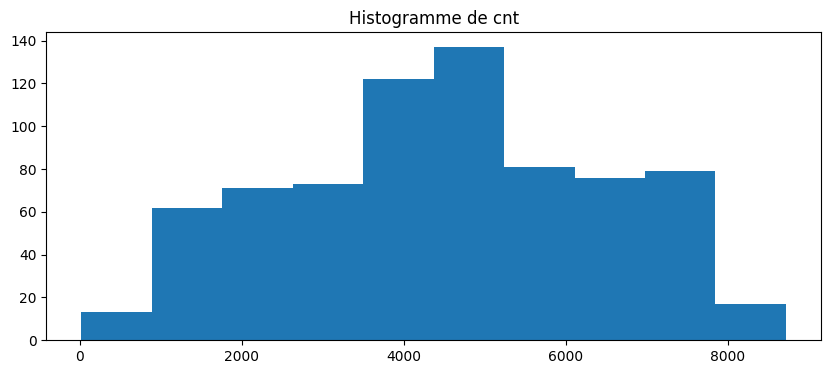

       registered_share  casual_share
count        731.000000    731.000000
mean           0.824402      0.175598
std            0.107375      0.107375
min            0.489676      0.013177
25%            0.785196      0.099321
50%            0.851216      0.148784
75%            0.900679      0.214804
max            0.986823      0.510324
        dteday   cnt season_name weather_name      temp       hum  windspeed
623 2012-09-15  8714      summer        clear  0.608333  0.501667   0.247521
637 2012-09-29  8555        fall        clear  0.542500  0.542917   0.227604
630 2012-09-22  8395      summer        clear  0.650000  0.646667   0.283583
447 2012-03-23  8362      spring  mist/cloudy  0.601667  0.694167   0.116300
504 2012-05-19  8294      spring        clear  0.600000  0.456250   0.083975
        dteday  cnt season_name     weather_name      temp       hum  \
667 2012-10-29   22        fall  light rain/snow  0.440000  0.880000   
26  2011-01-27  431      winter            clear  0.

In [6]:
# TODO: histogramme de cnt
plt.hist(df["cnt"])
plt.title("Histogramme de cnt")
plt.show()

# TODO: proportion moyenne registered/casual
df["registered_share"] = df["registered"] / df["cnt"]
df["casual_share"] = df["casual"] / df["cnt"]
print(df[["registered_share","casual_share"]].describe())

# TODO: top/bottom 5 jours
print(df.nlargest(5, "cnt")[["dteday","cnt","season_name","weather_name","temp","hum","windspeed"]])
print(df.nsmallest(5, "cnt")[["dteday","cnt","season_name","weather_name","temp","hum","windspeed"]])


## 5) Évolution temporelle : 2011 vs 2012

À faire :
- courbe `cnt` au fil du temps
- comparer **moyenne** et **total** 2011 vs 2012
- donner un chiffre d’évolution en %


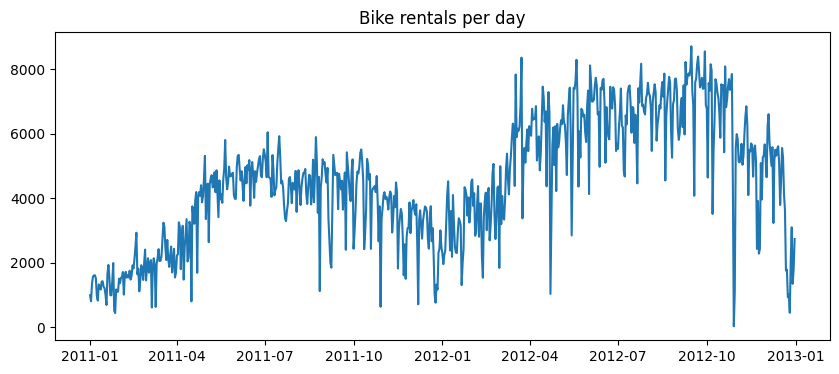

      count      sum         mean  median
year                                     
2011    365  1243103  3405.761644  3740.0
2012    366  2049576  5599.934426  5927.0
64.87579870694545 64.42531838260953


In [16]:
# TODO: time series
df_sorted = df.sort_values("dteday")
plt.plot(df_sorted["dteday"], df_sorted["cnt"])
plt.title("Bike rentals per day")
plt.show()

# TODO: stats par année
year_stats = df.groupby("year")["cnt"].agg(["count","sum","mean","median"])
print(year_stats)

# TODO: évolution %
inc_total = (year_stats.loc[2012, "sum"] - year_stats.loc[2011, "sum"]) / year_stats.loc[2011, "sum"] * 100
inc_mean = (year_stats.loc[2012, "mean"] - year_stats.loc[2011, "mean"]) / year_stats.loc[2011, "mean"] * 100
print(inc_total, inc_mean)


## 6) Saison / mois / jour de semaine

Objectif : rendre visible la saisonnalité.

À produire (au moins 2 graphiques) :
- moyenne `cnt` par **mois**
- moyenne `cnt` par **saison**
- bonus : `cnt` par **weekday** + interprétation (et plutôt la *composition* casual/registered)


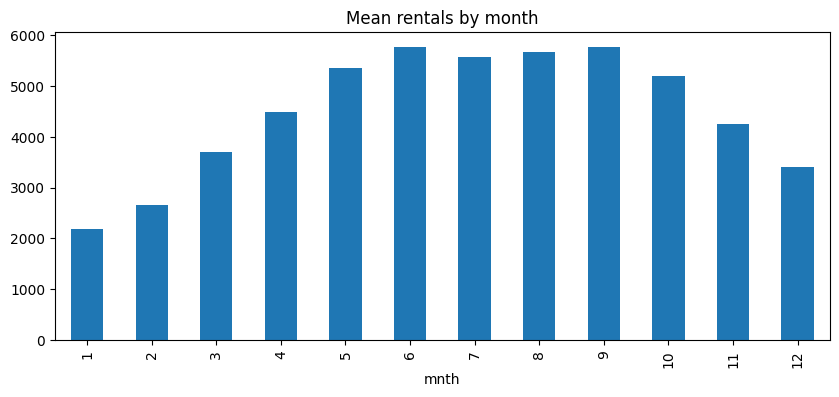

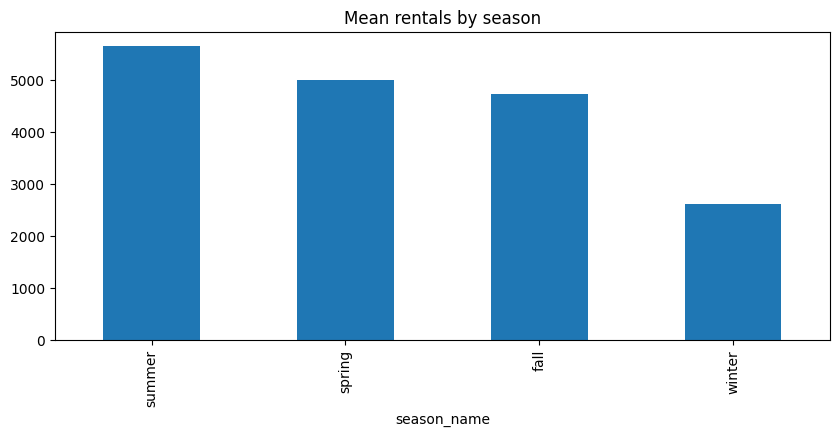

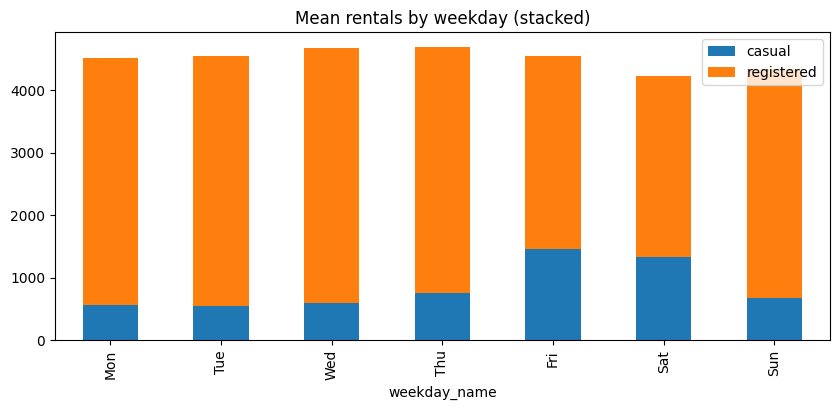

In [9]:
# TODO: moyenne par mois (bar)
month_mean = df.groupby("mnth")["cnt"].mean()
month_mean.plot(kind="bar")
plt.title("Mean rentals by month")
plt.show()

# TODO: moyenne par saison
season_mean = df.groupby("season_name")["cnt"].mean().sort_values(ascending=False)
season_mean.plot(kind="bar")
plt.title("Mean rentals by season")
plt.show()

# TODO: composition par weekday (casual vs registered)
weekday_mean = df.groupby("weekday_name")[["casual","registered"]].mean()
weekday_mean = weekday_mean.reindex(["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])  # si vous avez ces labels
weekday_mean.plot(kind="bar", stacked=True)
plt.title("Mean rentals by weekday (stacked)")
plt.show()


## 7) Météo : impact et robustesse des conclusions

À faire :
- comparer `cnt` selon `weathersit` / `weather_name` (boxplot ou bar)
- quantifier la baisse “mist” vs “clear”, et “rain/snow” vs “clear”
- comparer l’impact météo sur **casual** vs **registered**


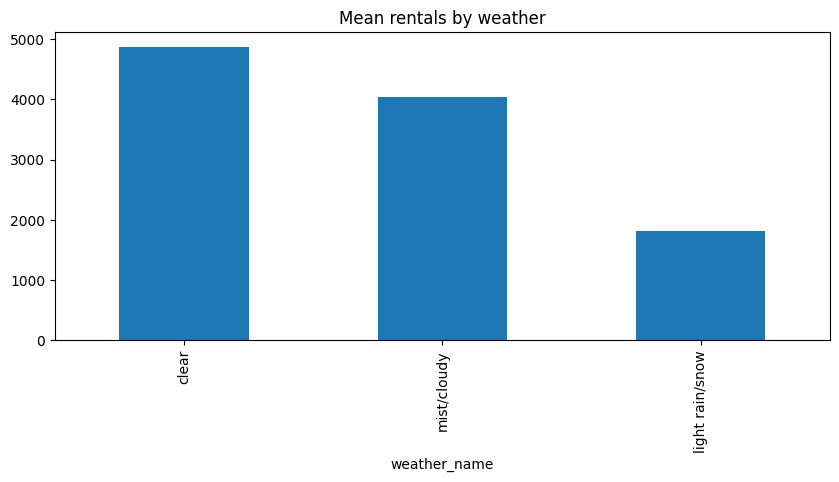

['mist/cloudy' 'clear' 'light rain/snow']
Mist vs clear: -17.243401666356156
Rain vs clear: -63.02307198229698


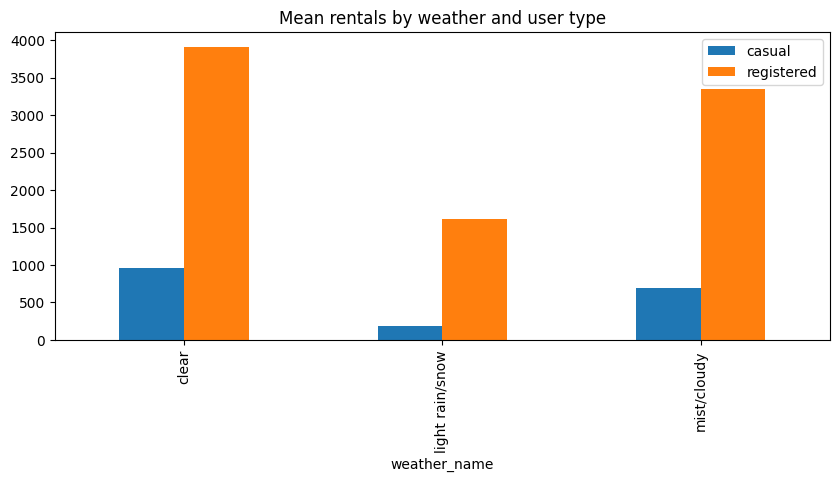

In [17]:
# TODO: moyenne par weather
weather_mean = df.groupby("weather_name")["cnt"].mean().sort_values(ascending=False)
weather_mean.plot(kind="bar")
plt.title("Mean rentals by weather")
plt.show()
print(df['weather_name'].unique())
# TODO: ratios / baisses en %
clear = weather_mean["clear"]
mist = weather_mean["mist/cloudy"]
rain = weather_mean["light rain/snow"]
print("Mist vs clear:", (mist - clear) / clear * 100)
print("Rain vs clear:", (rain - clear) / clear * 100)

# TODO: casual vs registered par météo
df.groupby("weather_name")[["casual","registered"]].mean().plot(kind="bar")
plt.title("Mean rentals by weather and user type")
plt.show()


## 8) Variables continues : température, humidité, vent

À faire :
- scatter `temp` (ou `temp_C`) vs `cnt` (+ corrélation)
- montrer si la relation est linéaire ou “plafonne”
- idem (rapide) pour `hum` et `windspeed`


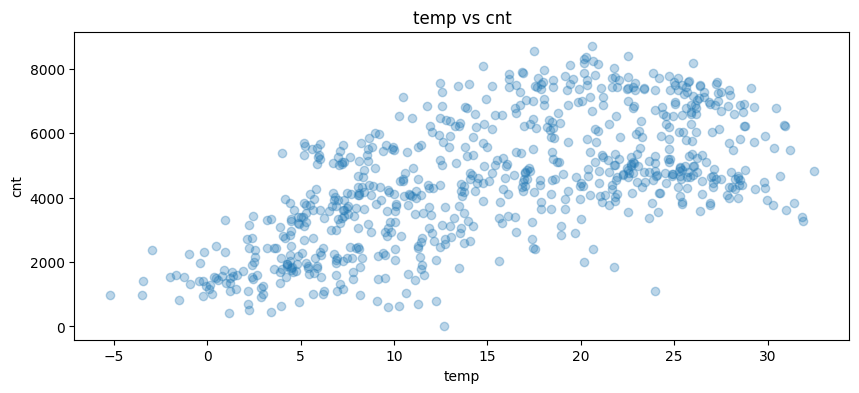

cnt          1.000000
atemp        0.631066
temp         0.627494
hum         -0.100659
windspeed   -0.234545
Name: cnt, dtype: float64


C:\Users\CYTech Student\AppData\Local\Temp\ipykernel_19524\443333361.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("temp_bin")["cnt"].mean()


temp_bin
Q1 cold    2615.076503
Q2         4186.568306
Q3         5591.104396
Q4 warm    5630.584699
Name: cnt, dtype: float64

In [18]:
# TODO: scatter temp vs cnt
x = df["temp_C"]
plt.scatter(x, df["cnt"], alpha=0.3)
plt.title("temp vs cnt")
plt.xlabel("temp")
plt.ylabel("cnt")
plt.show()

# TODO: corrélation (sur colonnes numériques)
df[["temp","atemp","hum","windspeed","cnt"]].corr()["cnt"].sort_values(ascending=False)
print(df[["temp","atemp","hum","windspeed","cnt"]].corr()["cnt"].sort_values(ascending=False))
# TODO: binner la température (quartiles) et comparer la moyenne de cnt
df["temp_bin"] = pd.qcut(df["temp"], 4, labels=["Q1 cold","Q2","Q3","Q4 warm"])
df.groupby("temp_bin")["cnt"].mean()


## 9) Jours ouvrés / week-end : la *composition* change

À faire :
- comparer `cnt` sur `workingday=1` vs `0`
- comparer surtout `casual_share` / `registered_share`
- donner 2 phrases d’insight chiffrées


                    cnt       casual   registered
workingday                                       
0           4330.168831  1371.134199  2959.034632
1           4584.820000   606.570000  3978.250000


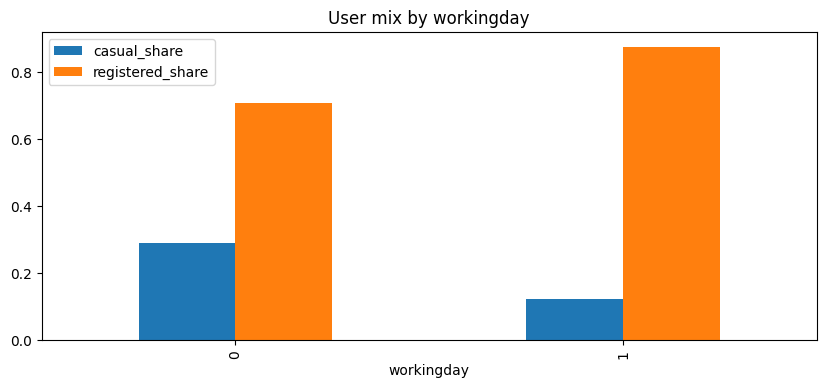

In [17]:
# TODO: stats workingday
stats = df.groupby("workingday")[["cnt","casual","registered"]].mean()
print(stats)

# TODO: parts
df["casual_share"] = df["casual"]/df["cnt"]
df["registered_share"] = df["registered"]/df["cnt"]
df.groupby("workingday")[["casual_share","registered_share"]].mean()

# TODO: graphique simple
shares = df.groupby("workingday")[["casual_share","registered_share"]].mean()
shares.plot(kind="bar")
plt.title("User mix by workingday")
plt.show()


## 10) (Optionnel) Mini exploration interactive

Si `ipywidgets` est dispo, vous pouvez explorer rapidement une relation variable→`cnt`.


In [ ]:
# Optionnel: petit widget interactif (ne pas bloquer si ipywidgets absent)
try:
    from ipywidgets import interact

    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    @interact(xcol=numeric_cols)
    def _plot(xcol):
        plt.figure(figsize=(8,3))
        plt.scatter(df[xcol], df["cnt"], alpha=0.25)
        plt.xlabel(xcol); plt.ylabel("cnt"); plt.title(f"{xcol} vs cnt")
        plt.show()
except Exception as e:
    print("ipywidgets non disponible (ok).", type(e).__name__)


## 11) Synthèse (à rendre)

Rédigez ici vos **5–8 insights** les plus parlants, avec :
- une phrase claire
- un chiffre (moyenne, ratio, %)
- une hypothèse causale *prudente* (corrélation ≠ causalité)


### Mes insights
1. Le service est très utilisé par les abonnés, donc utiliser pour des trajets quotidien, ex :travail/maison chiffre: 82% vs 18%

2. La chaleur est le facteur le plus important dans la demande/utilisation des vélos: corrélation entre temp et demande :0.627494, cf graphique rental by month/season où les demandes sont plus élevés pour les mois/saisons les plus chaudes. Vélo est un moyen de transport extérieur donc le confort de la température est important
3. La demande suit les jours de travails graph user by working day. Les users utilisent le vélo pour des travails quotidient entre trajet/maison commme un moyen de transport
4. La pluie on utilise moins le vélo que quand il fait beau. Logique c'est un vélo
5. le vélo est de plus en plus utilisé, les moyennes basses de 2011 sont inférieurs à 2012. Prix avantageux? plus agréable que le métro, plus libre

